## Import Libraries

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Create Models

Sentiment Analysis Model. Includes vocabulary embedding, LSTM layers and Linear layers.

In [131]:
class SentientAnalizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_dim):
        super(SentientAnalizer, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.Vocab_Embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=2, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self,x, hidden):
        emb = self.Vocab_Embedding(x).view(x.shape[0],x.shape[1],-1)
        #print (emb.shape)
        #print (hidden[0].shape)
        out, hidden = self.LSTM(emb, hidden)
        out = self.Linear1(out)
        # out = torch.relu(out)
        out = torch.celu(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

Price Prediction Model. Includes attention layer to understand the context of the variables, LSTM layers and Linear layers. Takes 9 variables and the sentiment output as inputs, and outputs the 9 variables for the next step (next day).

In [132]:
class StockPredictor(nn.Module):

    def __init__(self, input_size_stock,input_size_sentiment, hidden_size, num_layers, max_length):
        super(StockPredictor, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size_stock = input_size_stock
        self.input_size_sentiment = input_size_sentiment
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn_hidd = nn.Linear(self.hidden_size, max_length)
        self.attn_out = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.CombinedLayerSS = nn.Linear(self.input_size_stock+self.input_size_sentiment, self.hidden_size)
        self.LSTM = nn.LSTM(self.input_size_sentiment+self.input_size_stock, self.hidden_size,num_layers=num_layers, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.Linear2 = nn.Linear(self.hidden_size, self.input_size_stock)


    def forward(self,x, hidden, stock_news):
        attn_wights = F.softmax(self.attn_hidd(hidden[0][0]), dim=1)
        context = torch.bmm(attn_wights.unsqueeze(0), stock_news.unsqueeze(0))
        x_SS = torch.cat((x,context),dim=2)
        out, hidden = self.LSTM(x_SS, hidden)
        out = self.Linear1(out)
        out = self.dropout(out)
        # out = torch.relu(out)
        out = torch.celu(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

## Load Data

In [167]:
news_1 = pd.read_csv('../data/Preprocess/final_data/Crypto_Currency_News.csv') # news_np[0]
news_2 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrencies.csv') # news_np[1]
news_3 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrency.csv') # news_np[2]
news_4 = pd.read_csv('../data/Preprocess/final_data/Cryptomarkets.csv') # news_np[3]
news_5 = pd.read_csv('../data/Preprocess/final_data/eth.csv') # news_np[4]
news_6 = pd.read_csv('../data/Preprocess/final_data/ethfinance.csv') # news_np[5]
news_7 = pd.read_csv('../data/Preprocess/final_data/ethtrader.csv') # news_np[6]

stocks_norm = pd.read_csv('../data/Preprocess/final_data/finance_norm.csv')


news_dfs = [news_1, news_2, news_3, news_4, news_5, news_6, news_7]
col_names = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']

# import scaler
with open('../data/Preprocess/scaler.pkl', 'rb') as f:
    scaler = pkl.load(f)

In [134]:
news_1.head(1)

,date,tok_text_1,tok_text_2,tok_text_3,tok_text_4,tok_text_5,tok_text_6,tok_text_7,tok_text_8,tok_text_9,tok_text_10
0,1/10/2019,"[1, 60, 61, 62, 63, 64, 65, 66, 67, 60, 63, 62...","[1, 93, 94, 60, 95, 96, 60, 84, 97, 98, 99, 10...","[1, 110, 111, 112, 113, 114, 84, 19, 56, 115, ...","[1, 120, 121, 43, 122, 123, 124, 125, 67, 126,...","[1, 5, 10, 127, 129, 119, 67, 130, 131, 132, 1...","[1, 136, 137, 138, 139, 140, 141, 2, 0, 0, 0, ...","[1, 142, 143, 144, 145, 2, 0, 0, 0, 0, 0, 0, 0...","[1, 147, 148, 149, 67, 126, 150, 2, 151, 2, 0,...","[1, 29, 152, 153, 154, 2, 0, 0, 0, 0, 0, 0, 0,...","[1, 13, 155, 49, 84, 156, 2, 0, 0, 0, 0, 0, 0,..."


##### Reshape & Transform data to numpy

In [135]:
'''
example of cell in news_1:
'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]'
is saved as a string
'''
# change type
import ast
for df in news_dfs:
    for j in range(1,11):        
        df['tok_text_'+str(j)] = np.array(df['tok_text_'+str(j)].apply(lambda x: ast.literal_eval (x)))

In [136]:
# convert all dataframes to numpy
# news_1_np = news_1.to_numpy()
news_np = []
for df in news_dfs:
    news_np.append(df.to_numpy())

stocks_norm_np = stocks_norm.to_numpy()

# delete 1st column
# news_1_np = news_1_np[:,1:]
for i in range(len(news_np)):
    news_np[i] = np.delete(news_np[i], 0, 1)
stocks_norm_np = stocks_norm_np[:,1:]

# reshape from (n,10) lists to (n,10,15) numbers
for k in range(len(news_np)):
    news_np[k] = np.array([np.array([np.array(news_np[k][i][j]) for j in range(10)]) for i in range(news_np[k].shape[0])])

# print
for i in range(len(news_np)):
    print(news_np[i].shape)
print (stocks_norm_np.shape)
# print first row, already checked it is the first row from the CSVs
# print (news_np[0][0])
# print(stocks_norm_np[0])

(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 9)


##### Make dataset
Data is split in 1089 days for training and 7 days for testing. The test samples are the last 7 days of the dataset. For the nature of this problem, the volatility of cryptocurrency prices, and the unavailability of news of the future, the objective is to forecast up to a week ahead with a decent accuracy.

In [137]:
# shape dataset to pytorch dataset class    
class Dataset (torch.utils.data.Dataset):
    def __init__(self, data_stock, notice, target):
        self.data = data_stock.unsqueeze(1)
        self.notice = notice.unsqueeze(3)
        self.target = target.unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.notice[idx], self.target[idx]

# split dataset into train and test
# using news_1 and stocks_norm, use all except one week, we will predict this week in testing
# data_stock = torch.Tensor(stocks_norm_np[:,:]).float()
data_stock = torch.Tensor(stocks_norm_np[:-7,:]).float()
test_stock = data_stock[-1] # we will start forcast from the real value of the last day of the train set
test_stock = test_stock.unsqueeze(0).unsqueeze(0)
# data_news = torch.Tensor(news_np[0]).long() 
data_news = torch.Tensor(news_np[0][:-7,:,:]).long() # news_np[0] is news_1 (Crypto_Currency_News.csv), change to others as needed
target = data_stock[1:,:]
data_stock = data_stock[:-1,:]
print (data_stock.shape, data_news.shape, target.shape)

# create dataset
dataset = Dataset(data_stock, data_news, target)

torch.Size([1088, 9]) torch.Size([1089, 10, 15]) torch.Size([1088, 9])


## Start Model

Create model for Sentiment Analysis and Price Prediction

In [138]:
Senti = SentientAnalizer(1, 128, 256, 50000, 128) # 50000 is the size of the vocabulary, our dictionary has 49783 words
Stock = StockPredictor(9,256,256,9,10) # 9 is the number of variables in the stock # change second 9 to 4

In [139]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

Optimizer adds Senti parameters and Stock parameters so that they are trained together.

In [140]:
# optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.01) # lr=0.001
# loss function
criterion = nn.MSELoss()

Test everything works:

In [141]:

# test the dataloader
# for i, (data_stock, data_news, target) in enumerate(train_loader):
#     print (data_stock.shape, data_news.shape, target.shape)
#     # Test the model
#     data_news = data_news.squeeze(0)
#     hidde_senti = Senti.init_hidden(data_news.shape[0])
#     out_senti, hidden_senti = Senti(data_news, hidde_senti)
#     out_senti = out_senti[:,-1,:]
#     hidde_stock = Stock.init_hidden(data_stock.shape[0])
#     out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
#     print (out_stock.shape)
#     # Test the optimizer
#     optimizer.zero_grad()
#     loss = criterion(out_stock, target)
#     print(loss.item())
#     loss.backward()
#     optimizer.step()
#     break

In [142]:
# Test predict the next 5 days
# for i in range(5):    
#     out_stock, hidden_stock = Stock(out_stock, hidde_stock, out_senti)
#     print (out_stock.shape)

## Train Model

In [143]:
# train
epochs = 2 # 50 is overkill, do what you want
# array to store predictions
preds = []
for epoch in range(epochs):
    epoch_loss = 0
    e_preds = []
    hidde_senti = Senti.init_hidden(10)
    hidde_stock = Stock.init_hidden(1)
    print('-- Epoch', epoch+1, '--')
    for i, (data_stock, data_news, target) in enumerate(tqdm(train_loader)):
        data_news = data_news.squeeze(0)
        out_senti, hidden_senti = Senti(data_news, hidde_senti)
        out_senti = out_senti[:,-1,:]
        out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
        # hidde_stock = (hidde_stock[0].detach(), hidde_stock[1].detach())
        # store predictions
        e_preds.append(out_stock)
        # optimizer
        optimizer.zero_grad()   
        loss = criterion(out_stock, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i % 250 == 0: # 1096 steps
            print('Step:', i, ' Loss:', epoch_loss/(i+1))
            # print (i, epoch_loss/(i+1))
    preds.append(e_preds)
    print(epoch+1, '/', epochs, 'completed')
    print (epoch+1, 'Final Loss:', epoch_loss/(i+1), '\n')


-- Epoch 1 --


  0%|          | 1/1088 [00:00<06:12,  2.92it/s]

Step: 0  Loss: 0.07671113312244415


 23%|██▎       | 252/1088 [00:49<02:36,  5.33it/s]

Step: 250  Loss: 0.0047888525777491295


 46%|████▌     | 502/1088 [01:34<01:47,  5.45it/s]

Step: 500  Loss: 0.004394575925726747


 69%|██████▉   | 751/1088 [02:29<01:23,  4.03it/s]

Step: 750  Loss: 0.005847650295238924


 92%|█████████▏| 1001/1088 [03:36<00:24,  3.57it/s]

Step: 1000  Loss: 0.005254749062491779


100%|██████████| 1088/1088 [04:02<00:00,  4.48it/s]


1 / 2 completed
1 Final Loss: 0.005110817519960499 

-- Epoch 2 --


  0%|          | 1/1088 [00:00<05:50,  3.10it/s]

Step: 0  Loss: 0.1462504118680954


 23%|██▎       | 251/1088 [01:14<04:16,  3.26it/s]

Step: 250  Loss: 0.004537785075782554


 46%|████▌     | 501/1088 [02:23<02:42,  3.62it/s]

Step: 500  Loss: 0.0041800155410970175


 69%|██████▉   | 751/1088 [03:33<01:31,  3.68it/s]

Step: 750  Loss: 0.005637348548597694


 92%|█████████▏| 1001/1088 [04:45<00:25,  3.41it/s]

Step: 1000  Loss: 0.005170793294709838


100%|██████████| 1088/1088 [05:13<00:00,  3.47it/s]

2 / 2 completed
2 Final Loss: 0.005014442865464897 



In [106]:
out_stock_n = out_stock.tolist()
target_n = target.tolist()
out_stock_n = out_stock_n[0][0]
target_n = target_n[0][0]
# unnormalize the data using loaded scaler
out_stock_n = scaler.inverse_transform([out_stock_n])
target_n = scaler.inverse_transform([target_n])

In [107]:
# pretty print
df_out = pd.DataFrame(out_stock_n[0])
df_target = pd.DataFrame(target_n[0])
df_out = df_out.T
df_target = df_target.T
df_out.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_target.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_out.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1501.041536,1.710381e+10,1.025839e+06,0.077209,348385.075659,0.180695,29513.618792,0.00023,8789.539976


In [108]:
df_target.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1328.25948,1.877111e+10,1.233506e+06,0.068807,345834.991741,0.2084,38467.999922,0.000382,42551.000134


## Save Model

In [144]:
# save model
torch.save(Senti.state_dict(), 'saved_models/Senti_29_05.pth')
torch.save(Stock.state_dict(), 'saved_models/Stock_29_05.pth')

## Load and Test Model

In [145]:
# load a model
Senti_l = SentientAnalizer(1, 128, 256, 50000, 128) 
Stock_l = StockPredictor(9,256,256,9,10) 

In [146]:
Senti_l.load_state_dict(torch.load('saved_models/Senti_29_05.pth'))
Stock_l.load_state_dict(torch.load('saved_models/Stock_29_05.pth'))

<All keys matched successfully>

In [147]:
preds_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
optimizer_l = torch.optim.Adam(list(Senti_l.parameters())+list(Stock_l.parameters()), lr=0.01) # lr=0.001
criterion = nn.MSELoss()

##### Make predictions for the 1088 days of training

In [148]:
# We set the model to evaluation mode
# This is important because some layers behave differently during training and evaluation
# We can set the model back to training mode by calling model.train()
Senti_l.eval()
Stock_l.eval()

StockPredictor(
  (attn_hidd): Linear(in_features=256, out_features=10, bias=True)
  (attn_out): Linear(in_features=512, out_features=256, bias=True)
  (CombinedLayerSS): Linear(in_features=265, out_features=256, bias=True)
  (LSTM): LSTM(265, 256, num_layers=9, batch_first=True)
  (Linear1): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Linear2): Linear(in_features=256, out_features=9, bias=True)
)

In [149]:
# Predict all the data

# with torch.no_grad(): 
preds_l = []
hidde_senti = Senti_l.init_hidden(10)
hidde_stock = Stock_l.init_hidden(1)
print('-- Predictions --')
for i, (data_stock, data_news, target) in enumerate(preds_loader):
    data_news = data_news.squeeze(0)
    out_senti, hidden_senti = Senti_l(data_news, hidde_senti)
    out_senti = out_senti[:,-1,:]
    out_stock, hidden_stock = Stock_l(data_stock, hidde_stock, out_senti)
    # store predictions
    preds_l.append(out_stock)
    # optimizer
    optimizer_l.zero_grad()   
    loss = criterion(out_stock, target)
    loss.backward()
    optimizer_l.step()
    if i % 100 == 0: # 1088 steps
        print('Step:', i)
print('-- Preds completed --')

-- Predictions --
Step: 0
Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
-- Preds completed --


##### Forecast the next 7 days

In [150]:
fore_stock = out_stock # test_stock # 

We use torch.no_grad() to avoid tracking the gradients for the test set. We have already set the model to evaluation mode.

Here we take the last sentiment value and use it for the next 7 days, as we can't predict the sentiment for the future. 

For stock variables, we take the last prediction, and for each day of the forecast we take the output and use it as input for the next day.

In [153]:
# forcast the next 7 days
forecasts = []
forecasts.append(fore_stock) # add the start point
Stock_l.eval()
with torch.no_grad():
    for i in range(7):
        # predict the next day
        fore_stock, hidden_stock = Stock_l(fore_stock, hidde_stock, out_senti)
        # optimizer_l.zero_grad()
        optimizer_l.step()
        forecasts.append(fore_stock)
print(forecasts)

[tensor([[[0.2657, 0.1720, 0.2585, 0.6904, 0.2855, 0.6715, 0.0811, 0.0934,
          0.0728]]], grad_fn=<ViewBackward0>), tensor([[[0.2530, 0.1692, 0.2594, 0.6883, 0.2731, 0.6977, 0.0768, 0.1028,
          0.0991]]]), tensor([[[0.2419, 0.1662, 0.2575, 0.6934, 0.2610, 0.7262, 0.0721, 0.1132,
          0.1359]]]), tensor([[[0.2321, 0.1631, 0.2529, 0.7050, 0.2495, 0.7574, 0.0672, 0.1248,
          0.1839]]]), tensor([[[0.2233, 0.1601, 0.2458, 0.7223, 0.2385, 0.7916, 0.0624, 0.1375,
          0.2434]]]), tensor([[[0.2153, 0.1571, 0.2361, 0.7448, 0.2281, 0.8290, 0.0579, 0.1514,
          0.3148]]]), tensor([[[0.2079, 0.1543, 0.2240, 0.7722, 0.2182, 0.8697, 0.0539, 0.1664,
          0.3983]]]), tensor([[[0.2011, 0.1517, 0.2096, 0.8040, 0.2088, 0.9137, 0.0505, 0.1825,
          0.4940]]])]


In [154]:
# make forecast to numpy
# cant use forecast = forecast.detach().numpy() due to version issues, workaround:
forecast_np = np.array(torch.cat(forecasts, dim=0).tolist())
forecast_np = np.squeeze(forecast_np, axis=1)
# make preds to numpy
preds_np = np.array(torch.cat(preds_l, dim=0).tolist())
preds_np = np.squeeze(preds_np, axis=1)
real_values = stocks_norm_np[1:,:] # remove first row
print (forecast_np.shape)
print (preds_np.shape)
print (real_values.shape)

(8, 9)
(1088, 9)
(1095, 9)


In [155]:
# unnormalize the data using loaded scaler
real_values_un = scaler.inverse_transform(real_values)
preds_np_un = scaler.inverse_transform(preds_np)
forecast_np_un = scaler.inverse_transform(forecast_np)

## Results

In [156]:
# calculate standard deviation.
stds = []
for i in range(9):
    stds.append(np.std(real_values_un[:,i], axis=0))
for i in range(9):
    print (col_names[i], stds[i])

adj_close 1337.4726991204095
volume 10211521929.269737
num_trades_USDT 631839.7406452631
close_BTC 0.022021368239816732
num_trades_BTC 132399.17157028607
close_BNB 0.04479372888523323
num_trades_BNB 32263.902864333828
close_XRP 0.0004365633549043587
num_trades_XRP 12662.067767368158


Indicator of how well the model is doing:

In [157]:
# Our metric for evaluation will be how many predictions are within N standard deviations of the actual value
N = 0.3
# calculate how many predictions are within 0.3 standard deviations of the actual value
print("Predictions within 0.3 standard deviations of actual value:")
within_05 = []
for i in range(9):
    # within_05.append(np.sum(np.abs(preds_np_un[:,i] - real_values_un[:,i]) < N*stds[i]))
    within_05.append(np.sum(np.abs(preds_np_un[:,i] - real_values_un[:-7,i]) < N*stds[i]))

print (within_05)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_05[i]/1088*100))

# average of all
print ('Average: %.2f%%' % (np.sum(within_05)/1088/9*100))

Predictions within 0.3 standard deviations of actual value:
[992, 529, 575, 1009, 423, 848, 625, 1005, 584]
- adj_close: 91.18%
- volume: 48.62%
- num_trades_USDT: 52.85%
- close_BTC: 92.74%
- num_trades_BTC: 38.88%
- close_BNB: 77.94%
- num_trades_BNB: 57.44%
- close_XRP: 92.37%
- num_trades_XRP: 53.68%
Average: 67.30%


In [158]:
# same thing but for the forecast
print("Forecast within 0.3 standard deviations of actual value:")
within_05 = []
for i in range(9):
    within_05.append(np.sum(np.abs(forecast_np_un[1:,i] - real_values_un[-7:,i]) < N*stds[i]))

print (within_05)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_05[i]/7*100))

# average of all
print ('Average: %.2f%%' % (np.sum(within_05)/7/9*100))
print ('Average Closes: %.2f%%' % (np.sum(within_05[0]+within_05[3]+within_05[5]+within_05[7])/7/4*100))


Forecast within 0.3 standard deviations of actual value:
[7, 4, 0, 7, 2, 3, 6, 7, 0]
- adj_close: 100.00%
- volume: 57.14%
- num_trades_USDT: 0.00%
- close_BTC: 100.00%
- num_trades_BTC: 28.57%
- close_BNB: 42.86%
- num_trades_BNB: 85.71%
- close_XRP: 100.00%
- num_trades_XRP: 0.00%
Average: 57.14%
Average Closes: 85.71%


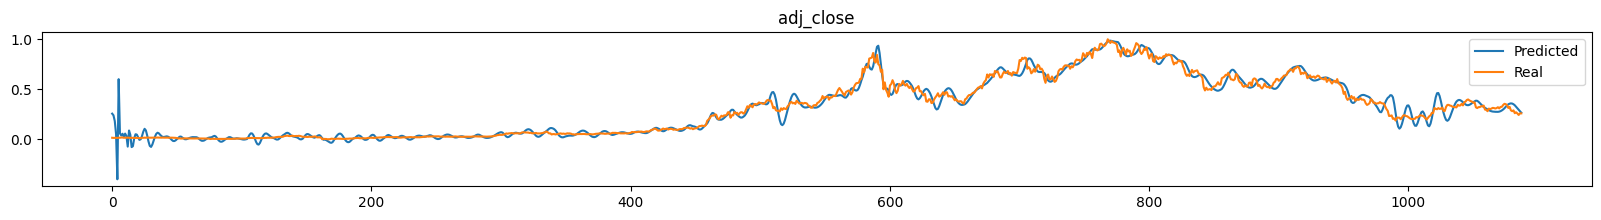

Last 5 predictions: 0.32520, 0.31085, 0.29568, 0.28032, 0.26567
Last 5 actual: 0.26948, 0.25817, 0.24290, 0.25887, 0.25899


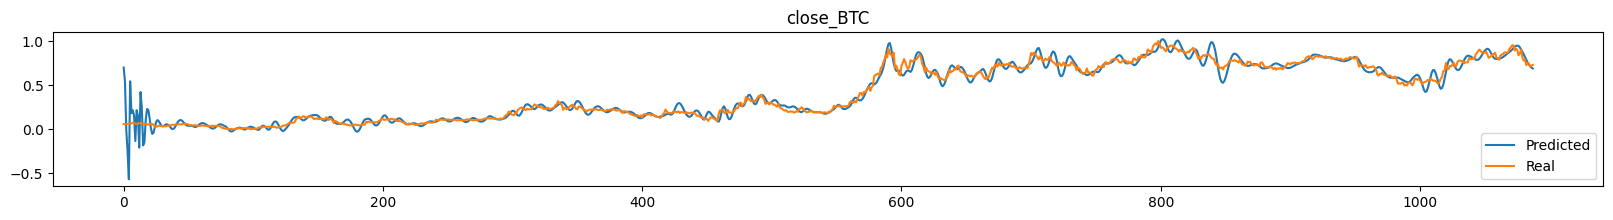

Last 5 predictions: 0.75828, 0.73330, 0.71498, 0.70038, 0.69036
Last 5 actual: 0.75222, 0.74746, 0.71056, 0.72289, 0.72919


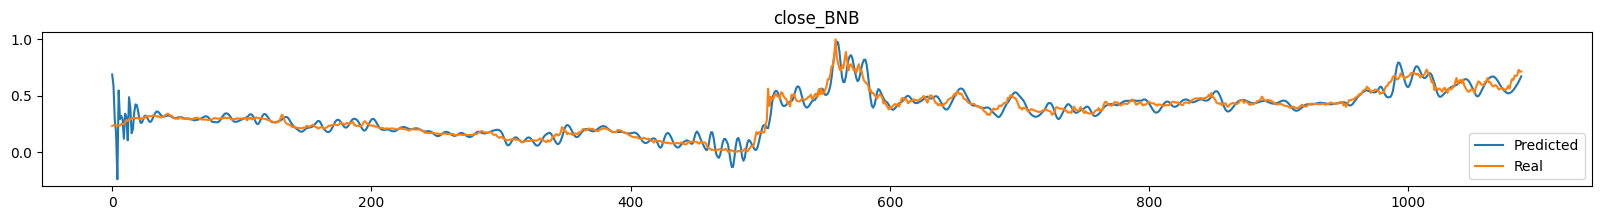

Last 5 predictions: 0.58536, 0.60374, 0.62394, 0.64698, 0.67149
Last 5 actual: 0.67205, 0.68608, 0.72898, 0.71134, 0.71494


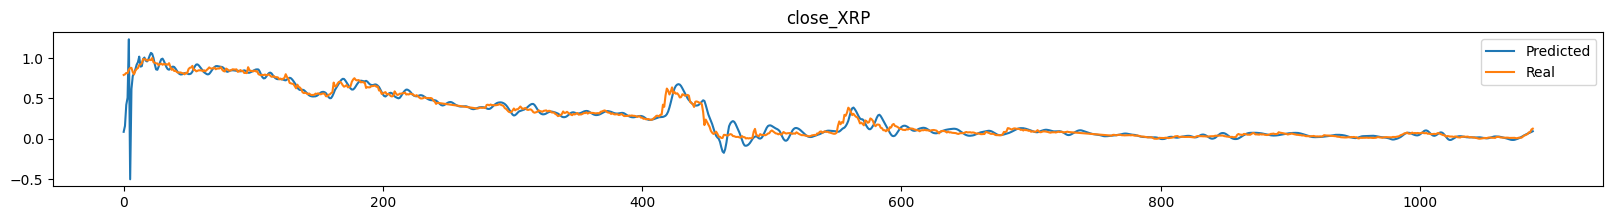

Last 5 predictions: 0.06412, 0.07116, 0.07802, 0.08507, 0.09340
Last 5 actual: 0.05884, 0.08049, 0.08232, 0.11545, 0.12537


In [165]:
# graph predictions vs actual
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,2))
    plt.plot(preds_np[:,i], label='Predicted')
    plt.plot(real_values[:-7,i], label='Real')
    plt.legend()
    plt.title(col_names[i])
    plt.show()
    print ('Last 5 predictions: %.5f, %.5f, %.5f, %.5f, %.5f' % (preds_np[-5,i], preds_np[-4,i], preds_np[-3,i], preds_np[-2,i], preds_np[-1,i]))
    print ('Last 5 actual: %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values[-12,i], real_values[-11,i], real_values[-10,i], real_values[-9,i], real_values[-8,i]))


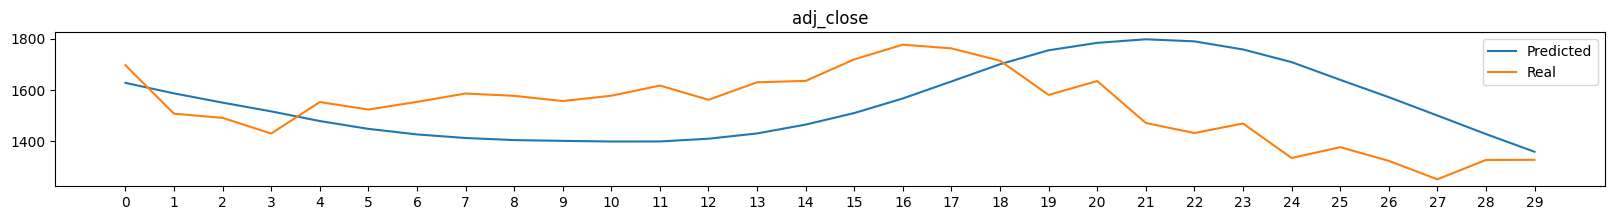

Last 5 predictions: 1639.53631, 1572.03798, 1500.71857, 1428.54628, 1359.66781
Last 5 actual: 1377.54138, 1324.38818, 1252.60779, 1327.68018, 1328.25952


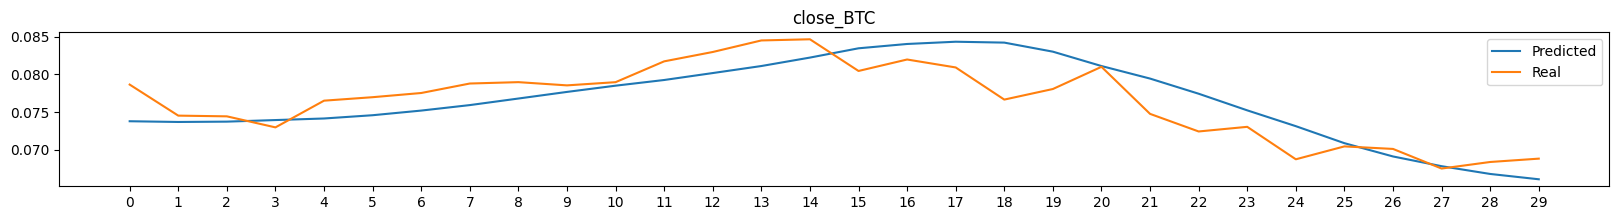

Last 5 predictions: 0.07086, 0.06910, 0.06780, 0.06678, 0.06607
Last 5 actual: 0.07043, 0.07010, 0.06749, 0.06836, 0.06881


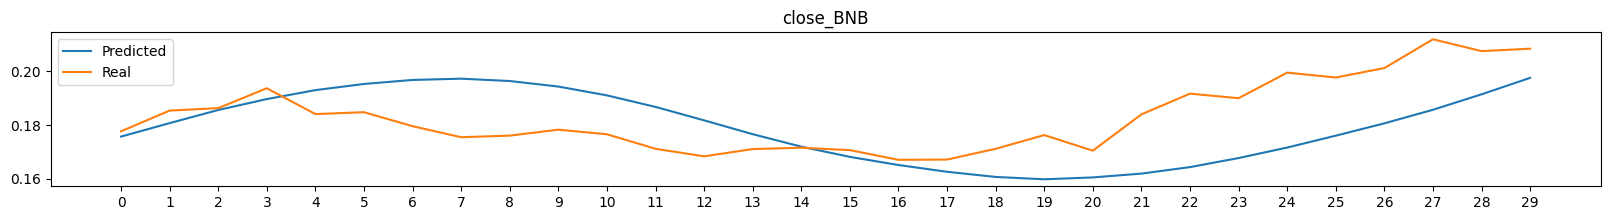

Last 5 predictions: 0.17608, 0.18066, 0.18570, 0.19145, 0.19756
Last 5 actual: 0.19770, 0.20120, 0.21190, 0.20750, 0.20840


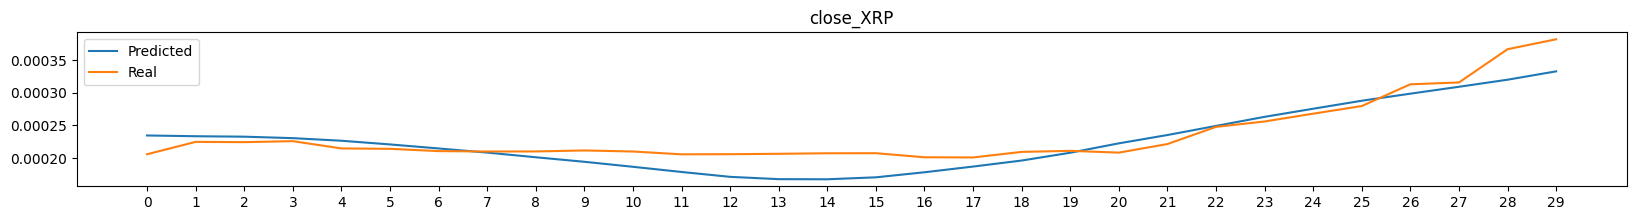

Last 5 predictions: 0.00029, 0.00030, 0.00031, 0.00032, 0.00033
Last 5 actual: 0.00028, 0.00031, 0.00032, 0.00037, 0.00038


In [163]:
# graph predictions vs actual
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,2))
    plt.plot(preds_np_un[-30:,i], label='Predicted')
    plt.plot(real_values_un[-37:-7,i], label='Real')
    plt.legend()
    plt.xticks(np.arange(0, 30, 1))
    plt.title(col_names[i])
    plt.show()
    print ('Last 5 predictions: %.5f, %.5f, %.5f, %.5f, %.5f' % (preds_np_un[-5,i], preds_np_un[-4,i], preds_np_un[-3,i], preds_np_un[-2,i], preds_np_un[-1,i]))
    print ('Last 5 actual: %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values_un[-12,i], real_values_un[-11,i], real_values_un[-10,i], real_values_un[-9,i], real_values_un[-8,i]))

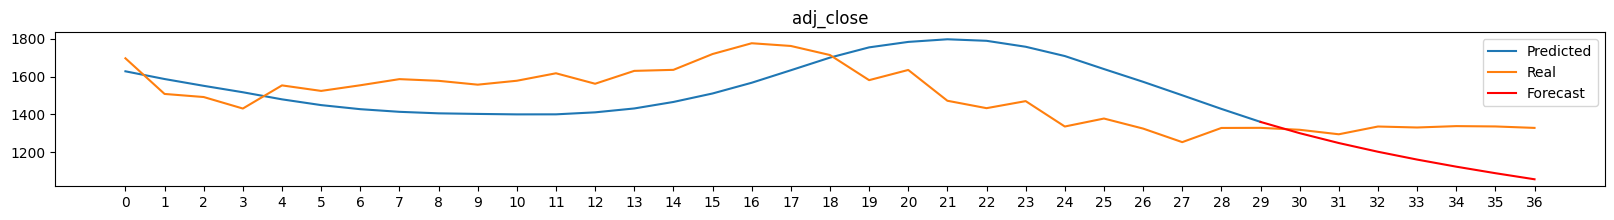

Last prediction: 1359.66781
Start: 1328.25952, Last week Real:     1317.99329, 1294.21680, 1335.32019, 1330.12769, 1337.41089, 1335.65234, 1327.97864
Start: 1359.66781, Last week Forecast: 1300.03484, 1247.85935, 1201.67841, 1160.29388, 1122.72427, 1088.16446, 1055.95264
Next Day Real:     DOWN
Week Forecast:     DOWN


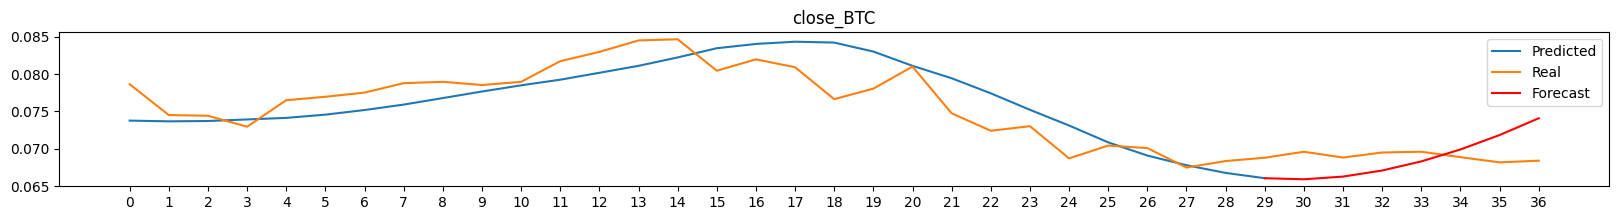

Last prediction: 0.06607
Start: 0.06881, Last week Real:     0.06961, 0.06883, 0.06950, 0.06961, 0.06888, 0.06819, 0.06841
Start: 0.06607, Last week Forecast: 0.06593, 0.06629, 0.06710, 0.06832, 0.06991, 0.07184, 0.07409
Next Day Real:     UP
Week Forecast:     UP


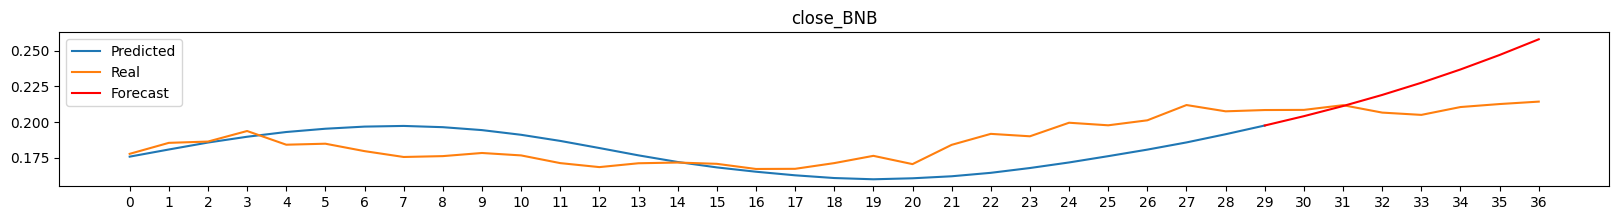

Last prediction: 0.19756
Start: 0.20840, Last week Real:     0.20850, 0.21180, 0.20660, 0.20500, 0.21050, 0.21260, 0.21430
Start: 0.19756, Last week Forecast: 0.20410, 0.21121, 0.21899, 0.22752, 0.23684, 0.24699, 0.25799
Next Day Real:     UP
Week Forecast:     UP


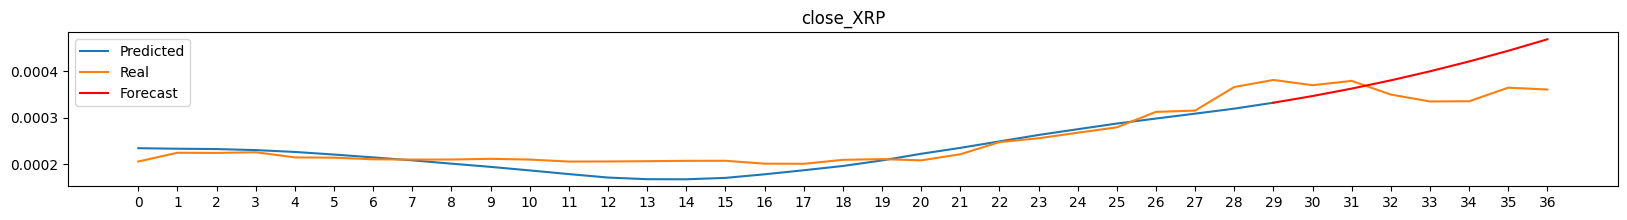

Last prediction: 0.00033
Start: 0.00038, Last week Real:     0.00037, 0.00038, 0.00035, 0.00034, 0.00034, 0.00036, 0.00036
Start: 0.00033, Last week Forecast: 0.00035, 0.00036, 0.00038, 0.00040, 0.00042, 0.00044, 0.00047
Next Day Real:     DOWN
Week Forecast:     UP


In [166]:
# graph actual vs predictions + forecast
# last 30 days + 7
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,2))
    plt.plot(preds_np_un[-30:,i], label='Predicted')
    plt.plot(real_values_un[-37:,i], label='Real')
    plt.plot(np.arange(29,37), forecast_np_un[:,i], label='Forecast', color="red")
    plt.legend()
    plt.xticks(np.arange(0, 37, 1.0))
    plt.title(col_names[i])
    plt.show()
    print ('Last prediction: %.5f' % preds_np_un[-1,i])
    print ('Start: %.5f, Last week Real:     %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values_un[-8,i], real_values_un[-7,i], real_values_un[-6,i], real_values_un[-5,i], real_values_un[-4,i], real_values_un[-3,i], real_values_un[-2,i], real_values_un[-1,i]))
    print ('Start: %.5f, Last week Forecast: %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f' % (forecast_np_un[0,i], forecast_np_un[1,i], forecast_np_un[2,i], forecast_np_un[3,i], forecast_np_un[4,i], forecast_np_un[5,i], forecast_np_un[6,i], forecast_np_un[7,i]))
    if real_values_un[-8,i] < real_values_un[-7,i]:
        print("Next Day Real:     UP")
    elif real_values_un[-8,i] > real_values_un[-7,i]:
        print("Next Day Real:     DOWN")
    else:
        print("Next Day Real:     SAME")
    if forecast_np_un[0,i] < forecast_np_un[7,i]:
        print("Week Forecast:     UP")
    elif forecast_np_un[0,i] > forecast_np_un[7,i]:
        print("Week Forecast:     DOWN")
    else:
        print("Week Forecast:     SAME")